In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from matplotlib import cm
from torch.utils.data import Dataset, DataLoader
from torch.tensor import Tensor
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

from hofer import SLayer, UpperDiagonalThresholdedLogTransform, prepare_batch
         
import warnings

from sklearn.model_selection import train_test_split
%matplotlib inline

# Setting up device to use

In [2]:
device = torch.device('cuda')

# Dataset and Data Loader

In [3]:
def clean_data(data):
    data[data == -1] = 0
    data[143:167, 223:247][data[143:167, 223:247] == 0] = 1
    return data 

def resize_data(data):
    im = Image.fromarray(np.uint8(cm.gist_earth(data, alpha=None)*255)[:, :, :3])
    resized_data = np.array(im.resize((112, 76)).convert('L'))
    return resized_data/resized_data.max()

class SeaIceDatasetSubLevel(Dataset):
    
    def __init__(self, seq_len, data_glob=glob('./data/*.pkl'), return_dims=False):
        self.seq_len = seq_len
        self.data_files = data_glob
        self.return_dims = return_dims
        
    def __len__(self):
        return len(self.data_files) - (self.seq_len + 1)
    
    def __getitem__(self, ix):
        X = torch.tensor([resize_data(clean_data(np.array(np.load(d)))) for d in self.data_files[ix:ix+self.seq_len]], dtype=torch.float32)
        y = resize_data(clean_data(np.load(self.data_files[ix+self.seq_len+1]))).flatten().astype(np.float32)
        
        if self.return_dims:
            trans = UpperDiagonalThresholdedLogTransform(.1)
            # Read in the dim0, and dim1 data.
            dim0 = [trans(torch.tensor(np.load('./sublevelset_barcode_numpy/' + d.split('/')[-1].split('.')[0] + '_dim0_sublevel.npy'))) for d in self.data_files[ix:ix+self.seq_len]]
            return X, dim0, y
        else:
            return X, y

# Setting up Model

In [4]:
class autoencoder(torch.nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3,  padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=(2,2)),
            
            torch.nn.Conv2d(16, 8, 3, padding=1),  # b, 8, 3, 3
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 1, 3, padding=1),  # b, 8, 3, 3
            torch.nn.BatchNorm2d(1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=(2,2))
        )
        self.decoder = nn.Sequential(
            torch.nn.Conv2d(1, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(16, 16, kernel_size=(2,2), stride=2),
            
            # b, 16, 5, 5
            torch.nn.Conv2d(16, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(8, 1, kernel_size=(2,2), stride=2),
#             nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
class AutoLSTM(torch.nn.Module):
    
    def __init__(self, encoder, decoder, input_dim, batch_size, hidden_dim, seq_length, num_layers, homology=False, N=75):
        super(AutoLSTM, self).__init__()
        
        # LSTM Variables.
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.input_size = input_dim
        
        # Homology info.
        self.homology = homology
        self.N = N
        
        # Encoder, decoder models.
        self.encoder = encoder
        self.decoder = decoder
        
        # Add the encoder to the model and turn off gradients for it.
        self.add_module('encoder', self.encoder)
        self.decoder.eval()
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Adding decoder letting model change up its gradients.
        self.add_module('decoder', self.decoder)
        self.decoder.eval()
        for param in self.decoder.parameters():
            param.requires_grad = False
            
        # Increase input for topo signatures.
        if self.homology:
            self.input_size = self.input_size + self.N
            self.slayer_dim0 = SLayer(self.N)
        else:
            self.N = 0
            
        self.lstm = torch.nn.LSTM(self.input_size, self.hidden_dim, num_layers=self.num_layers, 
                                  batch_first=True, dropout=.1)
        self.hidden = self.init_hidden()
        
    staticmethod
    def collation_station(self, batch):
        """
        Custom collation method for joining the batchs together
        based on seq length also.
        """
        # Collate X, and y batches as normal.
        X = torch.stack([b[0] for b in batch], 0)
        y = torch.stack([torch.from_numpy(b[-1]) for b in batch], 0)
        
        # For each batch prepare the dim0 features together.
        dim0_batch = []
        for b in batch:
            dim0_batch += b[1]
        dim0 = prepare_batch(dim0_batch)
        del dim0_batch
        return X, dim0, y
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.randn(self.num_layers, self.batch_size, self.hidden_dim, device=device),
                torch.randn(self.num_layers, self.batch_size, self.hidden_dim, device=device))
    
    def forward(self, x, dim0=torch.tensor([], device=device)):
        # X is (batch, seq, w, h)
        # Run inputs throuh conv nets.
        x = torch.cat([self.encoder(x[:, [ix], :, :]) for ix in range(self.seq_length)], dim=1)
        
        # Concatenate them.
        x = x.view(-1, self.seq_length, self.input_size - self.N)
        
        # Add the homology features.
        if self.homology:
            x = torch.cat([x, 
                           self.slayer_dim0(dim0).view(-1, self.seq_length, self.N)], dim=2)
            del dim0

        # Run through the lstm network.
        x, self.hidden = self.lstm(x, self.hidden)   
        
        # Run through the final decoder.
        x = self.decoder(x[:, -1, :].view(-1, 1, 19, 28))
        x = x.view(-1, 1, 8512)
        return x

# Training params

In [5]:
seq_length = 6
num_layers = 4
batch_size = 8
hidden_dim = 19*28
input_size = 19*28
N = 25
n_epochs = 50

In [6]:
auto = torch.load('autoencoder_paperv4.model')

In [7]:
model = AutoLSTM(
    homology=True, N=N,
    input_dim=input_size, seq_length=seq_length,
    hidden_dim=hidden_dim, batch_size=batch_size,
    num_layers=num_layers, encoder=auto.encoder, decoder=auto.decoder).to(device)

/uufs/chpc.utah.edu/common/home/u0897718/comp_topo/CompTopoProg/hofer.py:197: FutureWarning: Renaming in progress. In future use SLayerExponential.
  warnings.warn("Renaming in progress. In future use SLayerExponential.", FutureWarning)


In [8]:
all_glob = glob('./data/*.pkl')
train_glob = all_glob[:len(all_glob)-(seq_length*2)-3]
val_glob = all_glob[len(all_glob)-(seq_length*2)-3:]
print("train_size: {}, val_size: {}".format(len(train_glob), len(val_glob)))
train_dataset = SeaIceDatasetSubLevel(seq_length, data_glob=train_glob, return_dims=True)
val_dataset = SeaIceDatasetSubLevel(seq_length, data_glob=val_glob, return_dims=True)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0, drop_last=True, collate_fn=model.collation_station)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size, num_workers=0, drop_last=True, collate_fn=model.collation_station)

train_size: 333, val_size: 15


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001, weight_decay=1e-5)
criterion = torch.nn.MSELoss()

loss_mask = torch.tensor(np.load('resize_mask.npy').flatten().astype('float32')).cuda()

# Homology Training

In [8]:
val_storage = []
train_storage = []

In [ ]:
for epoch in range(n_epochs):
    epoch = epoch + n_epochs
    print("epoch: {}".format(epoch))
    
    model = model.train()
    train_losses = []
    print("Training Loop:")
    for ix, (X, dim0, y) in enumerate(train_loader):
        # Empty out the grads.
        optimizer.zero_grad()
        
        X = X.to(device)
        y = y.to(device)
        dim0 = (dim0[0].cuda(), dim0[1].cuda(), dim0[2], dim0[3])
        
        out = model(X, dim0)
        
        loss = criterion(out, y)
        loss.backward(retain_graph=True)
        optimizer.step()
        train_losses.append(loss.detach().item())
        
        del out, X, y, loss, dim0
    print("loss: {}".format(train_losses[-1]))
    train_storage.append(np.mean(train_losses))
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X, dim0, y in val_loader:
            # CUDA
            X = X.to(device)
            y = y.to(device)
            dim0 = (dim0[0].cuda(), dim0[1].cuda(), dim0[2], dim0[3])
            
            out = model(X, dim0)
            del X, dim0

            loss = criterion(out, y)
            del y
            val_losses.append(loss.detach().item())
            del loss
        print("val_loss: {}".format(np.mean(val_losses)))
        
    val_storage.append(np.mean(val_losses))
        
#     torch.save(model, './models/sub_hom/homology_model_e{}_l{:4f}'.format(epoch, np.mean(val_losses)))

epoch: 50
Training Loop:
loss: 0.15303535759449005
val_loss: 0.09828342497348785
epoch: 51
Training Loop:
loss: 0.1471797227859497
val_loss: 0.12595538794994354
epoch: 52
Training Loop:
loss: 0.1406000703573227
val_loss: 0.12162991613149643
epoch: 53
Training Loop:
loss: 0.11639564484357834
val_loss: 0.11653687059879303
epoch: 54
Training Loop:
loss: 0.1384773701429367
val_loss: 0.11153154075145721
epoch: 55
Training Loop:
loss: 0.11323483288288116
val_loss: 0.10589845478534698
epoch: 56
Training Loop:
loss: 0.12143012881278992
val_loss: 0.0999210923910141
epoch: 57
Training Loop:
loss: 0.11234196275472641
val_loss: 0.09453684091567993
epoch: 58
Training Loop:
loss: 0.11630294471979141
val_loss: 0.08925148099660873
epoch: 59
Training Loop:
loss: 0.10278702527284622
val_loss: 0.08415105938911438
epoch: 60
Training Loop:
loss: 0.09092827141284943
val_loss: 0.07875597476959229
epoch: 61
Training Loop:
loss: 0.09613632410764694
val_loss: 0.0738270953297615
epoch: 62
Training Loop:
loss: 0.

# Saving and plotting validation scores.

In [9]:
val_mods = glob("./models/sub_hom/homology_model*_l*")

In [10]:
vals = []
for mod in val_mods:
    vals.append(float(mod.split('_l')[1]))
vals = np.array(vals)

In [13]:
# vals = []
# for mod in val_mods:
#     vals.append(float(mod.split('_l')[1]))
# vals = np.array(vals)
# np.save('sublevel_homology_val_scorse', vals)

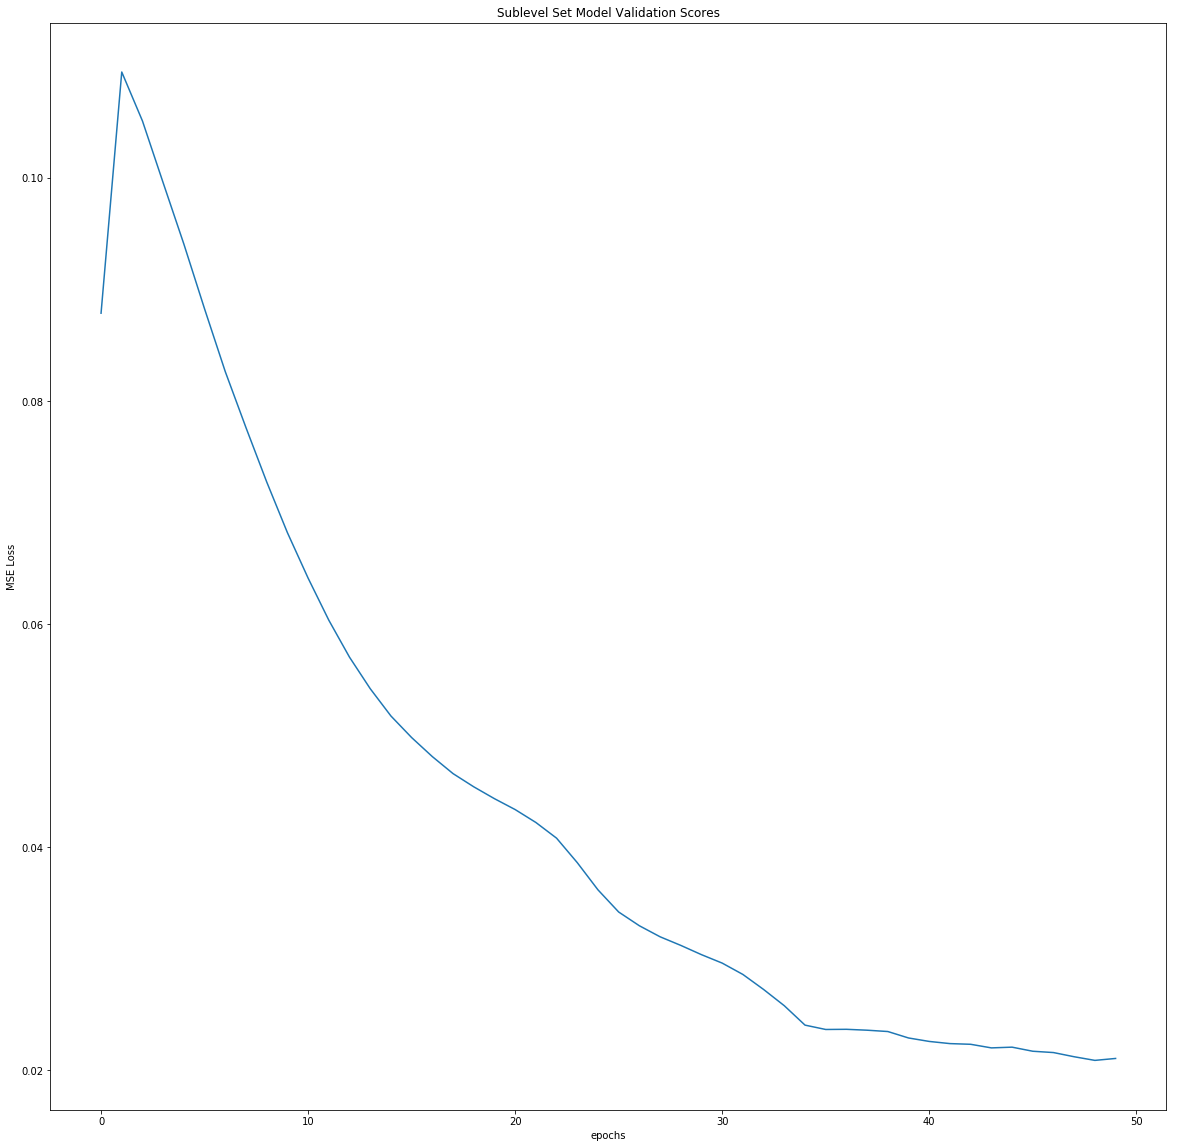

In [11]:
fig = plt.figure(figsize=(20,20))
plt.title('Sublevel Set Model Validation Scores')
plt.xlabel('epochs')
plt.ylabel('MSE Loss')
plt.plot(range(len(vals)), vals)
plt.savefig('SUB_Homology_val_plot')

# Getting best model

In [12]:
best_mod_ix = np.argmin(vals)
model = torch.load(val_mods[best_mod_ix])
val_mods[best_mod_ix]

'./models/sub_hom/homology_model_e98_l0.020890'

### Setting up non randomized val loader to ensure same predictions are found.

In [14]:
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, num_workers=0, drop_last=True, collate_fn=model.collation_station)

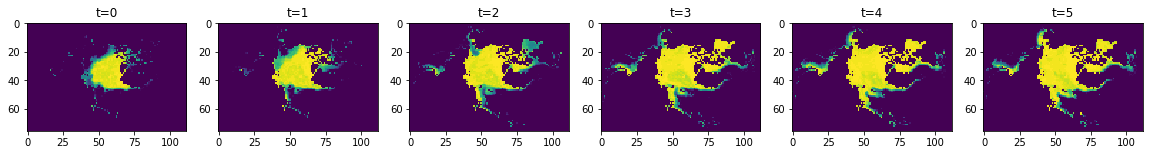

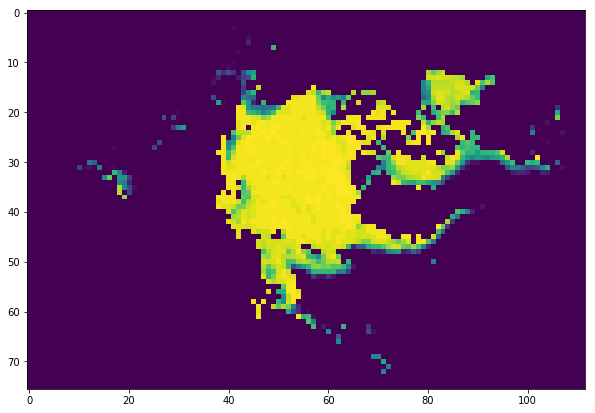

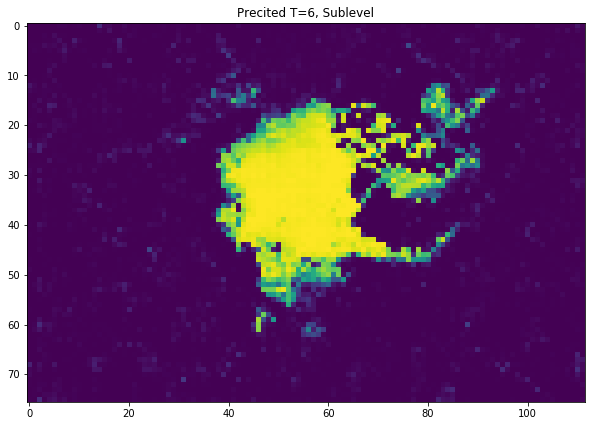

In [21]:
batch_ix = 0
for X, dim0, y in val_loader:
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(20,20))
    for ix, ax in enumerate(axs):
        ax.imshow(X[batch_ix, ix, :,:].cpu().numpy())
        ax.set_title('t={}'.format(ix))
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(y[batch_ix].cpu().numpy().reshape(76, 112))
    
    
    X = X.cuda()
    dim0 = (dim0[0].cuda(), dim0[1].cuda(), dim0[2], dim0[3])
    
    preds = model(X, dim0)
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(preds[batch_ix].detach().cpu().numpy().reshape(76, 112))
    plt.title('Precited T=6, Sublevel')
    fig.savefig('./images/predicted_sublevel.png')
    break